# **Analyzing Citi Bike patterns in New York**

*A project for course 42577 Introduction to Business Analytics by:*

* August B. Tollerup (s204139)
* Phillip C. Højbjerg (s184984)
* Jonas R. Gjerris (s184202)
* Line S. M. Petersen (s193973)

*Word count: 2496* (excluding this block, Contributions and Appendix)x

# Initialization

In [53]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import osmnx as ox
import holidays
from haversine import haversine, Unit
import shapely.geometry

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Dissable warnings
import warnings
warnings.filterwarnings('ignore')

# Setting seeds
np.random.seed(42)

# 1 Introduction

This study aims to bolster Citi Bike's business by providing strategic, data-driven insights for improved service efficiency and expansion strategies. The 2018 Citi Bike dataset from New York City is first analyzed and preprocessed, whereafter it is used in both prediction- and exploratory challenges aiming at forecasting the net bike demand at different stations and using surrounding points of interest to classify stations by demand respectively.

# 2 Data Analysis and Visualization

In order to select appropriate data science techniques for the prediction- and exploratory challenges, along with training effective models, the data will first be analysed and cleaned. Let us start with an overview of the data:


In [54]:
# Fetching data
data = pd.read_csv('Trips_2018.csv')

print(f"Size of the dataset: {data.shape}")
print("Data snippet:")
data.head()

Size of the dataset: (17548339, 14)
Data snippet:


,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


Above, we can see that the dataset has a total of 17,548,339 observations/trips and 13 features. Each trip starts and ends at a station with an ID, latitude and longitude - and has a trip duration, start- and end-time noted. In addition to the station-dependent features, the dataset holds information about the bike user such as usertype, birth year and gender, along with the id of the bike itself.

The index column `Unnamed` along with any NaN-values are removed, and `starttime` and `stoptime` converted to datetime format:

In [56]:
# Dropping unnamed column and removing NaN-values
data.drop(["Unnamed: 0"], axis=1, inplace=True)
observations = data.shape[0]
data.dropna(inplace=True)

# Converting times and dates to datetime format
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

print(f"Size of the dataset: {data.shape}")
print(f"Removed {observations-data.shape[0]} NaN-values")
print("Data snippet:")
data.head()

KeyError: "['Unnamed: 0'] not found in axis"

## 2.1 Station analysis

To gain insight into the stations, descriptive statistics are calculated for both the start- and end-stations:

In [ ]:
# Computing station statistics
start_station_data = data['start_station_id'].value_counts().reset_index()
end_station_data = data['end_station_id'].value_counts().reset_index()

print(f"""
Number of unique stations: {len(set(pd.concat([data['start_station_id'], data['end_station_id']])))}

Starting stations:
Number of different stations: {len(start_station_data)}
Range of trip counts: [{min(start_station_data['count'])},{max(start_station_data['count'])}]
Mean counts: {start_station_data['count'].mean():.2f}
STD of counts:  {start_station_data['count'].std():.2f}

Ending stations:
Number of different stations: {len(end_station_data)}
Range of trip counts: [{min(end_station_data['count'])},{max(end_station_data['count'])}]
Mean counts: {end_station_data['count'].mean():.2f}
STD of counts:  {end_station_data['count'].std():.2f}
""")


Number of unique stations: 850

Starting stations:
Number of different stations: 818
Range of trip counts: [1,150257]
Mean counts: 21449.68
STD of counts:  20476.06

Ending stations:
Number of different stations: 850
Range of trip counts: [1,149932]
Mean counts: 20642.17
STD of counts:  20665.91



There is a large deviation in the usage of the 850 stations; the symmetry of this deviation across start- and end-stations is investigated through plotting the stations' counts:

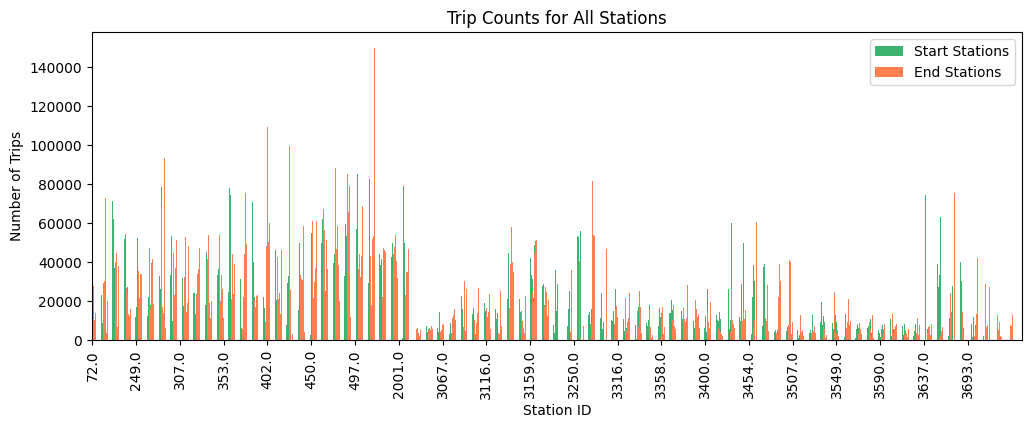

In [57]:
# Plotting the number of trips started and ended per station
plt.figure(figsize=(12, 4))
start_station_counts = data['start_station_id'].value_counts().sort_index()
end_station_counts = data['end_station_id'].value_counts().sort_index()

start_station_counts.plot(kind='bar', position=0, width=0.4, align='center', color='mediumseagreen', legend=True)
end_station_counts.plot(kind='bar', position=1, width=0.4, align='edge', color='coral', legend=True)

plt.legend(['Start Stations', 'End Stations'])
plt.title('Trip Counts for All Stations')
plt.xlabel('Station ID')
plt.ylabel('Number of Trips')

tick_positions = range(0, len(start_station_counts), max(1, len(start_station_counts) // 20))
plt.xticks(tick_positions, [start_station_counts.index[i] if i < len(start_station_counts) else '' for i in tick_positions], rotation=90)
plt.show()

## 2.2 Trip Durations

As before, statistics for the trip durations are calculated:

In [58]:
# Computing statistics for trip duration
print(f"""
Trip duration statistics:
Trip duration range (sec.): [{min(data['tripduration']):.2f}, {max(data['tripduration']):.2f}] (the latter being {max(data['tripduration']) / 60 / 60 / 24:.2f} days)
Mean: {data['tripduration'].mean():.2f}
Median: {data['tripduration'].median():.2f}
STD:  {data['tripduration'].std():.2f}""")


Trip duration statistics:
Trip duration range (sec.): [61.00, 19510049.00] (the latter being 225.81 days)
Mean: 988.47
Median: 605.00
STD:  18895.91


The maximum trip duration is much larger than both the mean and the median; therefore, it is likely that there are a few outlier trips. This is confirmed by the heavilly right-skewed distribution when plotted:

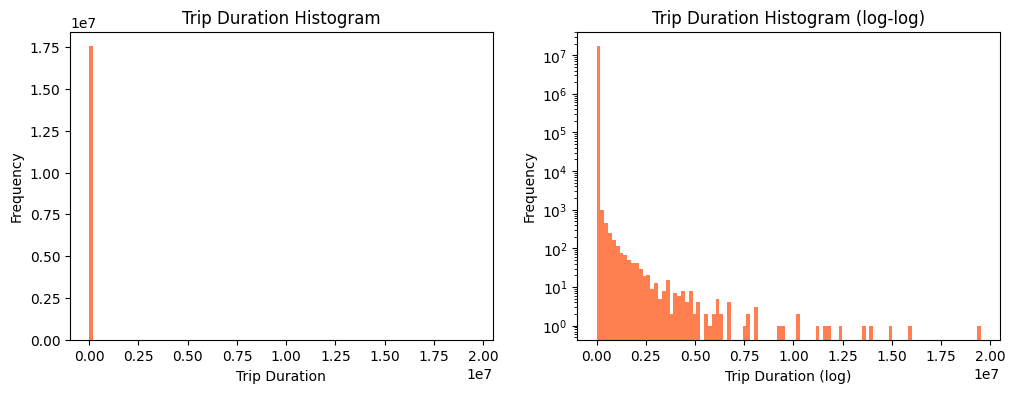

In [59]:
# Plotting the trip duration histogram on linear and log-log axes
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(data['tripduration'], bins=100, color='coral')
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.title('Trip Duration Histogram')

plt.subplot(122)
plt.hist(data['tripduration'], bins=100, log=True, color='coral')
plt.xlabel('Trip Duration (log)')
plt.ylabel('Frequency')
plt.title('Trip Duration Histogram (log-log)')
plt.show()

To improve the data-integrity, any observation with trip duration longer than the 99th percentile is deemed an outlier and removed:

In [60]:
# Removing data-point if trip duration larger than 99th percentile
data_outliers_removed = data[data.tripduration < data.tripduration.quantile(0.99)]

print(f"""
Number of outliers removed from dataset: {len(data) - len(data_outliers_removed)}

Cleaned trip duration statistics:
Trip duration range (seconds): [{min(data_outliers_removed['tripduration']):.2f}, {max(data_outliers_removed['tripduration']):.2f}] (the latter being {max(data_outliers_removed['tripduration']) / 60 / 60 / 24:.2f} days)
Mean: {data_outliers_removed['tripduration'].mean():.2f}
Median: {data_outliers_removed['tripduration'].median():.2f}
STD:  {data_outliers_removed['tripduration'].std():.2f}""")


Number of outliers removed from dataset: 175507

Cleaned trip duration statistics:
Trip duration range (seconds): [61.00, 3504.00] (the latter being 0.04 days)
Mean: 776.65
Median: 599.00
STD:  576.01


Plotting the histogram of the cleaned trip durations still shows a very right-skewed distribution, but the logarithmic axes are no longer needed for visualization:

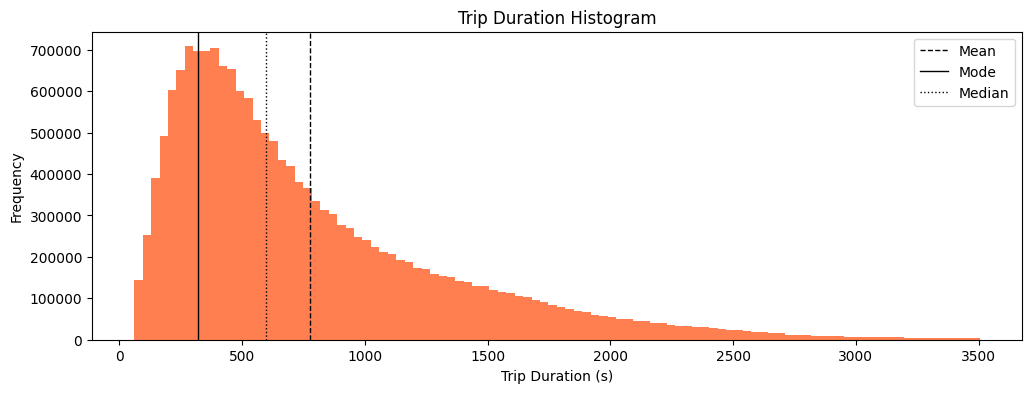

In [61]:
# Plotting the histogram of the cleaned trip durations 
plt.figure(figsize=(12, 4))
plt.hist(data_outliers_removed['tripduration'], bins=100, color='coral')
plt.xlabel('Trip Duration (s)')
plt.ylabel('Frequency')
plt.title('Trip Duration Histogram')
plt.axvline(data_outliers_removed['tripduration'].mean(), color='k', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(float(data_outliers_removed['tripduration'].mode()), color='k', linestyle='-', linewidth=1, label='Mode')
plt.axvline(data_outliers_removed['tripduration'].median(), color='k', linestyle=':', linewidth=1, label='Median')
plt.legend()
plt.show()

## 2.3 Usage Patterns

To understand the usage of the bikes, potential yearly, weekly and daily patterns are investigated. The function `create_p_d_dfs` below is used to create a dataframe of pickups and dropoffs in hourly intervals.

In [62]:
# Function defining dataframes with trip-count information where each row in the data-frame represents 
# an hourly interval, with the number of pickups and dropoffs that happened in that hour

def create_p_d_dfs(df, cluster_id = None):
    """ Creates three dataframes:
    1. Pickups: All trips which started per hour-interval
    2. Dropoffs: All trips which ended per hour-interval
    3. Pickups and dropoffs: Merged dataframe of the above two dataframes

    :param df: The dataframe from which the dataframes should be created
    :param cluster_id: (Optional) If given, the cluster id for which the dataframes should be created
    :return: pickups, dropoffs, pickups_and_dropoffs
    """
    # Pickups dataframe - counting all trips which started in the highest volume cluster per hour-interval
    if cluster_id is not None:
        pickups = df[df['start_cluster'] == cluster_id]['starttime'].value_counts().reset_index()
    else:
        pickups = df['starttime'].value_counts().reset_index()
    pickups.columns = ['time', 'pickups']
    pickups = pickups.set_index('time')
    pickups.sort_index(inplace=True)

    # Drop-off dataframe - all trips which ended in the highest volume cluster per hour-interval
    if cluster_id is not None:
        dropoffs = df[df['end_cluster'] == cluster_id]['stoptime'].value_counts().reset_index()
    else:
        dropoffs = df['stoptime'].value_counts().reset_index()
    dropoffs.columns = ['time', 'dropoffs']
    dropoffs = dropoffs.set_index('time')
    dropoffs.sort_index(inplace=True)

    # Merge dropoffs and pickups on index
    pickups_and_dropoffs = pickups.merge(dropoffs, left_index=True, right_index=True, how='outer')
    pickups_and_dropoffs = pickups_and_dropoffs.fillna(0)

    return pickups, dropoffs, pickups_and_dropoffs

The hourly intervalled pickups and dropoffs dataframe is created and extended with weekday- and month information:

In [63]:
# Flooring starttime and stoptime to nearest hour
count_data = data_outliers_removed[['starttime', 'stoptime']]
count_data['starttime'] = count_data['starttime'].dt.floor('H')
count_data['stoptime'] = count_data['stoptime'].dt.floor('H')

# Calculating pickups and dropoffs per hour interval
pickups, dropoffs, pickups_and_dropoffs = create_p_d_dfs(count_data)

# Adding weekdays and months to dataframe
pickups_and_dropoffs['weekday'] = [d.weekday() for d in pickups_and_dropoffs.index]
pickups_and_dropoffs['month'] = [d.month for d in pickups_and_dropoffs.index]

print(f"""
Sanity check: 
Total amount of pickups = Total amount of dropoffs: {pickups['pickups'].sum()==dropoffs['dropoffs'].sum()}""")


Sanity check: 
Total amount of pickups = Total amount of dropoffs: True


Plotting the amount of trips per month reveals, unsurprisingly, that the warmer months are most popular for bike-rides in NYC:

In [64]:
# Plotting the pickups and dropoff counts for each month
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'Oktober', 'November', 'December']
pick_drop = [pickups_and_dropoffs[pickups_and_dropoffs['month'] == i+1]['pickups'].sum() for i, month in enumerate(months)]

fig = go.Figure(data=[go.Bar(x=months, y=pick_drop, marker_color='coral')])
fig.update_layout(xaxis_title="Months", yaxis_title="Total Pickups", title="Monthly Pickups Summary", title_x=0.5, width=900,  height=400)
fig.show()

A similar plot can be created for the weekdays:

In [65]:
# Plotting the pickups and dropoff counts for weekday
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pick_drop = [pickups_and_dropoffs[pickups_and_dropoffs['weekday'] == i]['pickups'].sum() for i, day in enumerate(days)]

fig = go.Figure(data=[go.Bar(x=days, y=pick_drop, marker_color='coral')])
fig.update_layout(xaxis_title="Weekdays", yaxis_title="Total Pickups", title="Weekly Pickups Summary", title_x=0.5, width=900,  height=400)
fig.show()

There seems to be fewer trips in the weekends, suggesting that the bikes are primarily used by work-commuters; this is confirmed when the trips are plotted at an hourly interval for all weekdays:

In [66]:
# Plotting the pickups in hourly intervals for every day of the week
fig = go.Figure()
for i, weekday in enumerate(days):
    weekdata = pickups_and_dropoffs[pickups_and_dropoffs['weekday'] == i]
    grouped_data = weekdata.groupby(weekdata.index.hour).sum()[["pickups", "dropoffs"]]

    index = grouped_data.index
    pickups = grouped_data['pickups']
    fig.add_trace(go.Scatter(x=index, y=pickups, mode='lines', name=f'{weekday}'))

fig.update_layout(title='Pickups per weekday', xaxis_title='Hour of day', yaxis_title='Number of trips', title_x=0.5, width=900,  height=400)

for time in [7, 10, 16, 19]:
    fig.add_shape(type="line", x0=time, y0=0, x1=time, y1=300000, line=dict(color="RoyalBlue", width=1, dash="dot"))
fig.show()

There is a very clear usage pattern where peaks correspond to rush-hour during the week - confirming the New Yorker commuter hypothesis - while a smooth curve is seen on weekends. Both patterns would be great features in predicting pickups and dropoffs.

## 2.4 Station Location Analysis

Finally, the station locations are investigated to ensure that each station has a unique location within NYC. 

In [67]:
# Investigating station IDs with multiple locations exists
grouped = data_outliers_removed.groupby('start_station_id').agg({'start_station_latitude': 'nunique', 'start_station_longitude': 'nunique'})

consistent_stations = (grouped['start_station_latitude'] == 1) & (grouped['start_station_longitude'] == 1)
inconsistent_stations = grouped[~consistent_stations]

if not inconsistent_stations.empty:
    inconsistent_ids = grouped[~consistent_stations].index.tolist()
    print(f"Inconsistent station_ids with more than one unique latitude/longitude pair: {inconsistent_ids}")
else:
    print("All station_ids have exactly one unique latitude/longitude pair.")


Inconsistent station_ids with more than one unique latitude/longitude pair: [530.0]


It appears that station 530 is listed at multiple locations, this is explored further:

In [68]:
# Getting the lattitude and longitude for inconsistent stations and their usage
inconsistent_data = data_outliers_removed[data_outliers_removed['start_station_id'].isin(inconsistent_ids)]
count_pairs = inconsistent_data.groupby(['start_station_id', 'start_station_latitude', 'start_station_longitude']).size().reset_index(name='count')

count_pairs.head()

,start_station_id,start_station_latitude,start_station_longitude,count
0,530.0,40.771497,-73.990460,2534
1,530.0,40.771522,-73.990541,42588


The difference in location is minute and could be caused by moving the station across the street; therefore all entries for station 530 is kept. The station locations are now investigated to be within NYC by plotting them:

In [69]:
# Getting locations for unique station IDs
start_counts = data_outliers_removed['start_station_id'].value_counts().reset_index()
start_counts.columns = ['station_id', 'start_count']
data_start = data_outliers_removed.drop_duplicates('start_station_id')[['start_station_id', 'start_station_latitude', 'start_station_longitude']].copy()
data_start.columns = ['station_id', 'latitude', 'longitude']

end_counts = data_outliers_removed['end_station_id'].value_counts().reset_index()
end_counts.columns = ['station_id', 'end_count']
data_end = data_outliers_removed.drop_duplicates('end_station_id')[['end_station_id', 'end_station_latitude', 'end_station_longitude']].copy()
data_end.columns = ['station_id', 'latitude', 'longitude']

combined_data = pd.concat([data_start, data_end])
unique_stations = combined_data.drop_duplicates('station_id')
station_counts = pd.merge(start_counts, end_counts, on='station_id', how='outer').fillna(0)
unique_stations = pd.merge(unique_stations, station_counts, on='station_id', how='left').fillna(0)
unique_stations['counts'] = unique_stations['start_count'] + unique_stations['end_count']
unique_stations.drop(['start_count', 'end_count'], axis=1, inplace=True)

In [70]:
# Plotting unique stations
fig = go.Figure(data=go.Scatter(
    x = unique_stations['longitude'],
    y = unique_stations['latitude'],
    mode = 'markers',
    marker = dict(
        size = 5,
        color = 'coral',
    )
))

fig.update_layout(
    title = 'Location of stations',
    xaxis_title = 'Longitude',
    yaxis_title = 'Latitude',
)

fig.show()

Some stations seem to be in Canada, these are outliers and will be removed:

In [71]:
# Getting outlier stations
canada_stations = unique_stations[(unique_stations['longitude'] > -73.8) & (unique_stations['latitude'] > 45)].groupby('station_id')

# Removing outliers from dataset
data_outliers_removed = data_outliers_removed[(data_outliers_removed['start_station_latitude'] < 45) & (data_outliers_removed['start_station_longitude'] < -73.8)]
data_outliers_removed = data_outliers_removed[(data_outliers_removed['end_station_latitude'] < 45) & (data_outliers_removed['end_station_longitude'] < -73.8)]

print("Outlier stations in Canada:")
canada_stations.head()

Outlier stations in Canada:


,station_id,latitude,longitude,counts
607,3488.0,45.506364,-73.569463,6.0
752,3650.0,45.506264,-73.568906,134.0


The "cleaned" stations can now be plotted on a map of NYC:

In [72]:
def single_map_plotter(TITLE, PLOT_DATA, COLOR, TEXT, ZOOM=10, SIZE=10, LEGEND=False):
    fig = make_subplots(rows=1, cols=1, subplot_titles=[TITLE], specs=[[{'type': 'mapbox'}]], horizontal_spacing=0.01)

    if LEGEND:
        unique_clusters = COLOR.unique()
        for cluster in unique_clusters:
            cluster_data = PLOT_DATA[PLOT_DATA['cluster'] == cluster]
            fig.add_trace(go.Scattermapbox(
                lat=cluster_data['latitude'],
                lon=cluster_data['longitude'],
                mode='markers',
                marker=go.scattermapbox.Marker(size=SIZE, color=cluster,  sizemode='area', sizemin=4),
                text="Station Id: " + cluster_data['station_id'].astype(str) + "<br>" + "Cluster: " + cluster_data['cluster'].astype(str),
                hoverinfo='text',
                name=f"Cluster {cluster}"))
    else:
        fig.add_trace(go.Scattermapbox(
            lat=PLOT_DATA['latitude'],
            lon=PLOT_DATA['longitude'],
            mode='markers',
            marker=go.scattermapbox.Marker(size=SIZE, color=COLOR, sizemode='area', sizemin=4),
            text=TEXT,
            hoverinfo='text'))

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox=dict(center=go.layout.mapbox.Center(lat=40.73, lon=-73.99), zoom=ZOOM),
        margin={"r":0,"t":0,"l":0,"b":0},
        showlegend=LEGEND,
        annotations=[dict(text=TITLE, x=0.5, y=0.95, xref='paper', yref='paper', showarrow=False,
            font=dict(size=20, family='Arial Black', color='darkblue'),
            bgcolor='lightblue')])

    fig.show()

In [73]:
# Prepare data for plotting
clean_unique_stations = unique_stations[(unique_stations['latitude'] < 45) & (unique_stations['longitude'] < -73.8)]
plot_data = pd.DataFrame(clean_unique_stations)

# Prepare data for plotting and plot
TITLE = 'All Stations'
COLOR = 'coral'
TEXT = "Station Id: " + plot_data['station_id'].astype(str)

single_map_plotter(TITLE, plot_data, COLOR, TEXT, ZOOM=10, SIZE=7)

With all stations being in NYC, outliers and Nan-values removed, and the data properly formatted, the dataset is now ready to be used in the prediction challenge.

# 3 Predictive Challenge

The predictive challenge focuses on predicting station bike demands in order to accurately reposition bikes overnight on the basis of the Citi Bike dataset through clustering and regression models. 


## 3.1 Spatial clustering of stations

The station map against NYC's grid system shows evenly distributed stations which, coupled with the requirement of minimum 20 clusters, indicates that DBSCAN with its arbitrary cluster shapes and counts is non-optimal for this problem as its usage would counterintuitively require hyperparameter tuning towards a minimum amount of clusters.

Alternatively, K-means and a Gaussian Mixture Model (GMM) with Expectation-Maximization are used, as they allow setting the number of clusters. The models are evaluated on their silhouette scores, from fitted KMeans and GMM for 20-40 clusters; the best clustering model is then determined by comparing these scores.

In [86]:
# Setting seed
seed = 0

# Setting the range of clusters to test
n_clusters_range = range(20, 41)

# Lists to store silhouette and distortion scores
silhouette_scores_kmeans = []
silhouette_scores_gmm = []
distortion_scores_kmeans = []

for n_clusters in range(20, 41):
    # KMeans
    km = KMeans(n_clusters=n_clusters, random_state=seed, n_init='auto')
    kmeans_labels = km.fit_predict(clean_unique_stations[['latitude', 'longitude']])
    silhouette_kmeans = silhouette_score(clean_unique_stations[['latitude', 'longitude']], kmeans_labels)
    distortion_kmeans = np.sum(pairwise_distances_argmin_min(clean_unique_stations[['latitude', 'longitude']], km.cluster_centers_)[1])

    # Appending
    silhouette_scores_kmeans.append(silhouette_kmeans)
    distortion_scores_kmeans.append(distortion_kmeans)

    # Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_clusters, random_state=0)
    gmm_labels = gmm.fit_predict(clean_unique_stations[['latitude', 'longitude']])
    silhouette_gmm = silhouette_score(clean_unique_stations[['latitude', 'longitude']], gmm_labels)

    silhouette_scores_gmm.append(silhouette_gmm)

In [87]:
# Plotting the silhouette scores for each cluster count
n_clusters_range = list(n_clusters_range)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=n_clusters_range,
    y=silhouette_scores_kmeans,
    mode='lines+markers',
    name='KMeans - Silhouette Score',
    line=dict(color='coral'),
))

fig.add_trace(go.Scatter(
    x=n_clusters_range,
    y=silhouette_scores_gmm,
    mode='lines+markers',
    name='GMM - Silhouette Score',
    line=dict(color='mediumseagreen'),
))

fig.update_layout(
    title='Clustering Evaluation',
    xaxis_title='Number of Clusters',
    yaxis_title='Score',
    autosize=False,
    width=1200,
    height=400,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
)

fig.show()

KMeans outperforms GMM with a peak silhouette score around 0.415 at 20 clusters, indicating moderate cluster quality. Given NYC's grid layout and evenly scattered bike stations, well-separated clustering is challenging - the only apparent spatial clustering is created by the East River. Analyzing the KMeans' distortion score will offer insights into within-cluster variance:

In [88]:
# Plotting the distortion score for each cluster count of KMeans
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=n_clusters_range,
    y=distortion_scores_kmeans,
    mode='lines+markers',
    name='KMeans - Distortion Score',
    line=dict(color='coral'),
))

fig.update_layout(
    title='Clustering Evaluation',
    xaxis_title='Number of Clusters',
    yaxis_title='Score',
    autosize=False,
    width=1200,
    height=400,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    showlegend=True,
)

fig.show()

The Distortion plot usually reveals an 'elbow' point, indicating that adding more clusters beyond this point does not significantly reduce within-cluster variance; however, no clear elbow is present in this plot. Considering both plots, $N=20$ clusters is chosen for the KMeans algorithm:

In [89]:
# Using Kmeans to create 20 clusters
km=KMeans(20, n_init='auto', random_state=seed)
km.fit(clean_unique_stations[['latitude', 'longitude']])
clean_unique_stations.loc[:, 'cluster'] = km.labels_

In [90]:
# Printing information about the highest-volume cluster
highest_vol_cluster = clean_unique_stations.groupby('cluster')['counts'].sum().reset_index().sort_values('counts', ascending=False).iloc[0]['cluster']
print(f"Highest Volume Cluster: {highest_vol_cluster}")

df_high_vol_cluster = clean_unique_stations[clean_unique_stations['cluster'] == highest_vol_cluster]
print(f"Amount of stations in cluster: {len(df_high_vol_cluster)}")
print(f"Amount of trips in cluster: {sum(df_high_vol_cluster['counts'])}")

Highest Volume Cluster: 4.0
Amount of stations in cluster: 58
Amount of trips in cluster: 5356912.0


The station clusters can be plotted to gain insight into their distribution:

In [96]:
# Prepare data for plotting
plot_data = pd.DataFrame(clean_unique_stations)
plot_data = plot_data.sort_values(by='cluster')

# Prepare data for plotting and plot
TITLE = 'Clustered Stations'
COLOR = plot_data['cluster']
TEXT = "Station Id: " + plot_data['station_id'].astype(str) + "<br>" + "Cluster: " + plot_data['cluster'].astype(str)

single_map_plotter(TITLE, plot_data, COLOR, TEXT, SIZE=6, LEGEND=True)

The highest volume cluster appears encompass the notorious Greenwich Village! The clusters can now be mapped onto the original cleaned dataframe:

In [97]:
# Mapping station IDs to their cluster
station_to_cluster_dict = {row['station_id']: row['cluster'] for _, row in clean_unique_stations.iterrows()}
data_outliers_removed['start_cluster'] = data_outliers_removed['start_station_id'].map(station_to_cluster_dict)
data_outliers_removed['end_cluster'] = data_outliers_removed['end_station_id'].map(station_to_cluster_dict)

data_outliers_removed.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,8.0,15.0
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,8.0,15.0
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,8.0,8.0
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,8.0,8.0
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,8.0,8.0


We can now visualize the amount of pickups/dropoffs within each cluster

In [138]:
# Initialize lists to store the counts
pickups = []
dropoffs = []

# Loop over the clusters
for i in range(20):
    pickups.append(len(data_outliers_removed[data_outliers_removed['start_cluster'] == i]))
    dropoffs.append(len(data_outliers_removed[data_outliers_removed['end_cluster'] == i]))

clusters = list(range(20))  # Cluster IDs

fig = go.Figure(data=[
    go.Bar(name='Pickups', x=clusters, y=pickups),
    go.Bar(name='Dropoffs', x=clusters, y=dropoffs)
])

# Change the bar mode
fig.update_layout(barmode='group', title='Pickups and Dropoffs for each Cluster')

fig.show()

print(f"""Pickups and dropoffs in cluster 7: \n\tPickups: {pickups[7]}\n\tDropoffs: {dropoffs[7]}\n""")
print(f"""Pickups and dropoffs in cluster 18: \n\tPickups: {pickups[18]}\n\tDropoffs: {dropoffs[18]}""")

Pickups and dropoffs in cluster 7: 
	Pickups: 0
	Dropoffs: 117

Pickups and dropoffs in cluster 18: 
	Pickups: 10161
	Dropoffs: 12133


Geographically, cluster 7 makes a lot of sense, being the only cluster in New Jersey.
But as it contains zero pickups, it will be excluded from the remaning analysis. 

## 3.2 Predicting the Demand for a Cluster of Stations

To predict pickups and dropoffs within a cluster at specific time-points, data wrangling is performed so each observation includes a timepoint along with the counts of pickups and dropoffs that happened in the following hour. This is applied to the highest volume cluster:

In [139]:
# Flooring starttime and stoptime to nearest hour
data_high_vol_cluster = data_outliers_removed[['starttime', 'stoptime', 'start_cluster', 'end_cluster']].copy()
data_high_vol_cluster['starttime'] = pd.to_datetime(data_high_vol_cluster['starttime']).dt.floor('H')
data_high_vol_cluster['stoptime'] = pd.to_datetime(data_high_vol_cluster['stoptime']).dt.floor('H')

# Calculating pickups and dropoffs per hour interval
pickups, dropoffs, pickups_and_dropoffs = create_p_d_dfs(data_high_vol_cluster, highest_vol_cluster)

print(f"""
Sanity check:
Amount of trips in cluster = pickups+dropoffs in cluster: {sum(df_high_vol_cluster['counts'])==sum(pickups_and_dropoffs['pickups'] + pickups_and_dropoffs['dropoffs'])}""")

pickups_and_dropoffs.head()


Sanity check:
Amount of trips in cluster = pickups+dropoffs in cluster: True


,pickups,dropoffs
time,,
2018-01-01 00:00:00,19.0,18.0
2018-01-01 01:00:00,30.0,25.0
2018-01-01 02:00:00,14.0,11.0
2018-01-01 03:00:00,10.0,13.0
2018-01-01 04:00:00,7.0,6.0


With the dataframe defined, the following lagged features can be created:

- Lagged demand 1 hour back
- Lagged demand 24 hours back
- Lagged demand 168 hours back

The 1-hour lag causes predictions to depend on the previous hour which is not ideal, but will still be included. Additionally, based on the data analysis, features for *rushhour* (7am-10am and 4pm-7pm), *weekend*, *summer* and *holiday* will be created as these are hypothesized to have an impact on the demand. Since all features are within similar ranges, standardization is not necessary.

Since a model has to be fitted for each cluster, below `ClusterBuster` class is created to easily generate features and fit either a Linear Regression model, acting as a baseline, or a Random Forest Regressor (RFR):

In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

class ClusterBuster:
    """Class to model the demand.
    """
    def __init__(self, cluster_id, cluster_df, baseline = False, print_info=True):
        """Initialize the ClusterBuster object.

        :param cluster_id: The cluster id for which the object should be created
        :param cluster_df: The dataframe for the cluster id
        """
        self.cluster_id = cluster_id
        self.cluster_df = cluster_df[['starttime', 'stoptime', 'start_cluster', 'end_cluster']]
        self.model_dropoffs = None
        self.model_pickups = None
        self.pickups = None
        self.dropoffs = None
        self.X_p = None
        self.y_p = None
        self.X_d = None
        self.y_d = None
        self.pred_pickups = None
        self.pred_dropoffs = None
        self.pickups_test = None
        self.dropoffs_test = None
        self.linear_model_metrics = None
        self.print_info = print_info
        self.baseline = baseline
        
        if self.print_info:
            print(f"ClusterBuster object created for cluster {cluster_id}")
        # Floor starttime and stoptime to nearest hour
        self.cluster_df['starttime'] = pd.to_datetime(self.cluster_df['starttime']).dt.floor('H')
        self.cluster_df['stoptime'] = pd.to_datetime(self.cluster_df['stoptime']).dt.floor('H')

        # Creating pickups dataframe - counting all trips which started in the highest volume cluster per hour-interval
        pickups = self.cluster_df[self.cluster_df['start_cluster'] == self.cluster_id]['starttime'].value_counts().reset_index()
        pickups.columns = ['time', 'pickups']
        pickups = pickups.set_index('time')
        pickups.sort_index(inplace=True)

        # Drop-off dataframe - all trips which ended in the highest volume cluster per hour-interval
        dropoffs = self.cluster_df[self.cluster_df['end_cluster'] == self.cluster_id]['stoptime'].value_counts().reset_index()
        dropoffs.columns = ['time', 'dropoffs']
        dropoffs = dropoffs.set_index('time')
        dropoffs.sort_index(inplace=True)

        # merge dropoffs and pickups on index
        pickups_and_dropoffs = pickups.merge(dropoffs, left_index=True, right_index=True, how='outer')
        # replace NaN values associated with the merge with 0
        pickups_and_dropoffs = pickups_and_dropoffs.fillna(0)

        self.pickups_and_dropoffs = pickups_and_dropoffs

    def create_features(self, include = ['rushhour', 'weekend', 'summer', 'holiday']):
        """Creates features for the cluster dataframe.
        """

        # Create new feature columns
        if self.print_info:
            print("Creating lag features")
        self.pickups_and_dropoffs['1hLagPickups'] = self.pickups_and_dropoffs['pickups'].shift(1)
        self.pickups_and_dropoffs['24hLagPickups'] = self.pickups_and_dropoffs['pickups'].shift(24)
        self.pickups_and_dropoffs['168hLagPickups'] = self.pickups_and_dropoffs['pickups'].shift(168)

        self.pickups_and_dropoffs['1hLagDropoffs'] = self.pickups_and_dropoffs['dropoffs'].shift(1)
        self.pickups_and_dropoffs['24hLagDropoffs'] = self.pickups_and_dropoffs['dropoffs'].shift(24)
        self.pickups_and_dropoffs['168hLagDropoffs'] = self.pickups_and_dropoffs['dropoffs'].shift(168)

        self.pickups_and_dropoffs.replace(np.nan, 0, inplace=True)

        # Create feature for rushhour or not - defined as 7-10 and 16-19
        if 'rushhour' in include:
            if self.print_info:
                print("Creating rushhour feature")
            self.pickups_and_dropoffs['rushhour'] = 0
            self.pickups_and_dropoffs.loc[(self.pickups_and_dropoffs.index.hour >= 7) & (self.pickups_and_dropoffs.index.hour <= 10), 'rushhour'] = 1
            self.pickups_and_dropoffs.loc[(self.pickups_and_dropoffs.index.hour >= 16) & (self.pickups_and_dropoffs.index.hour <= 19), 'rushhour'] = 1

        if 'weekend' in include:
            # Create feature for weekend or not - defined as 5-6
            if self.print_info:
                print("Creating weekend feature")
            self.pickups_and_dropoffs['weekend'] = 0
            self.pickups_and_dropoffs.loc[(self.pickups_and_dropoffs.index.dayofweek >= 5), 'weekend'] = 1

        if 'summer' in include:
            # Create feature for hotter-months (April-September)
            if self.print_info:
                print("Creating summer feature")
            self.pickups_and_dropoffs['summer'] = 0
            self.pickups_and_dropoffs.loc[(self.pickups_and_dropoffs.index.month >= 4) & (self.pickups_and_dropoffs.index.month <= 9), 'summer'] = 1

        if 'holiday' in include:
            # add holiday feature
            if self.print_info:
                print("Creating holiday feature")
            self.pickups_and_dropoffs['holiday'] = 0
            us_holidays = holidays.UnitedStates()

            # we have hours in index so we need to convert to date
            self.pickups_and_dropoffs['date'] = self.pickups_and_dropoffs.index.date

            # iterate over all dates and check if it is a holiday
            for date in self.pickups_and_dropoffs['date'].unique():
                if date in us_holidays:
                    self.pickups_and_dropoffs.loc[self.pickups_and_dropoffs['date'] == date, 'holiday'] = 1

            # drop date column
            self.pickups_and_dropoffs.drop('date', axis=1, inplace=True)

        # .......................................................

        # All features except pickups and dropoffs
        self.features = self.pickups_and_dropoffs.columns.drop(['pickups', 'dropoffs'])

        if self.print_info:
            print(f"Features created for cluster {self.cluster_id}")
            print(f"Features: {self.features}")

        self.pickups = self.pickups_and_dropoffs[["pickups"] + list(self.features)]
        self.dropoffs = self.pickups_and_dropoffs[["dropoffs"] + list(self.features)]
        
        self.pickups_train = self.pickups.loc[(self.pickups.index.month >= 1) & (self.pickups.index.month <= 10)]
        self.pickups_test = self.pickups.loc[(self.pickups.index.month >= 11) & (self.pickups.index.month <= 12)]

        self.dropoffs_train = self.dropoffs.loc[(self.dropoffs.index.month >= 1) & (self.dropoffs.index.month <= 10)]
        self.dropoffs_test = self.dropoffs.loc[(self.dropoffs.index.month >= 11) & (self.dropoffs.index.month <= 12)]

        self.X_p = self.pickups_train[self.features]
        self.y_p = self.pickups_train["pickups"]

        self.X_d = self.dropoffs_train[self.features]
        self.y_d = self.dropoffs_train["dropoffs"]

        # Assert that pickups_test has the full date range
        fact_range_drop = pd.date_range(start=self.dropoffs_test.index.min(), end="2019-01-01", freq='H')
        # if missing dates, add them with 0 pickups
        if len(fact_range_drop) != len(self.dropoffs_test):
            missing_dates = list(set(fact_range_drop) - set(self.dropoffs_test.index))
            for date in missing_dates:
                self.dropoffs_test.loc[date] = 0
            self.dropoffs_test.sort_index(inplace=True)
        
        fact_range_pick = pd.date_range(start=self.pickups_test.index.min(), end="2019-01-01", freq='H')
        # if missing dates, add them with 0 pickups
        if len(fact_range_pick) != len(self.pickups_test):
            missing_dates = list(set(fact_range_pick) - set(self.pickups_test.index))
            for date in missing_dates:
                self.pickups_test.loc[date] = 0
            self.pickups_test.sort_index(inplace=True)
        
        if self.print_info:
            print("Length of pickup test set: ", len(self.pickups_test))
            print("Length of dropoff test set: ", len(self.dropoffs_test))

    def create_model(self):
        """Creates an RF model for the cluster dataframe. or a baseline Logistic Regression model.
        """
        if self.baseline:
            self.model_pickups = LinearRegression()
            self.model_dropoffs = LinearRegression()

        else:
            self.model_pickups = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
            self.model_dropoffs = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

        if self.print_info:
            print("="*50)
            print(f"Models created for cluster {self.cluster_id}")
            print("Fitting for pickups and dropoffs...")
        
        self.model_pickups.fit(self.X_p, self.y_p)
        self.model_dropoffs.fit(self.X_d, self.y_d)
        
        if self.print_info:
            print("Models fitted")
            print("="*50)

    def predict(self):
        """Predicts the demand for the cluster dataframe.
        """
        self.pred_pickups = self.model_pickups.predict(self.pickups_test[self.features])
        self.pred_dropoffs = self.model_dropoffs.predict(self.dropoffs_test[self.features])

    def metrics(self, format_print = False):
        """Returns the metrics for the cluster dataframe.
        """
        from sklearn.metrics import mean_squared_error, mean_absolute_error

        metrics = {
            "pickups": {
                "MSE": mean_squared_error(self.pickups_test["pickups"], self.pred_pickups),
                "MAE": mean_absolute_error(self.pickups_test["pickups"], self.pred_pickups),
                "R2": self.model_pickups.score(self.X_p, self.y_p)
            },
            "dropoffs": {
                "MSE": mean_squared_error(self.dropoffs_test["dropoffs"], self.pred_dropoffs),
                "MAE": mean_absolute_error(self.dropoffs_test["dropoffs"], self.pred_dropoffs),
                "R2": self.model_dropoffs.score(self.X_d, self.y_d)
            }
        }

        if format_print and self.print_info:
            for key, value in metrics.items():
                print(f"Results for {key.capitalize()}:")
                for metric, metric_value in value.items():
                    print(f"  {metric}: {metric_value:.4f}")
                print() 

        return metrics

To test the ClusterBuster, it is used on the highest volume cluster to create a dataframe with pickups, dropoffs, lagged and boolean features:

In [181]:
# Creating a ClusterBuster instance of highest volume cluster
cluster_buster = ClusterBuster(highest_vol_cluster, data_outliers_removed)
cluster_buster.create_features()
cluster_buster.pickups_and_dropoffs.head()

ClusterBuster object created for cluster 4.0
Creating lag features
Creating rushhour feature
Creating weekend feature
Creating summer feature
Creating holiday feature
Features created for cluster 4.0
Features: Index(['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs',
       '24hLagDropoffs', '168hLagDropoffs', 'rushhour', 'weekend', 'summer',
       'holiday'],
      dtype='object')
Length of pickup test set:  1465
Length of dropoff test set:  1465


,pickups,dropoffs,1hLagPickups,24hLagPickups,168hLagPickups,1hLagDropoffs,24hLagDropoffs,168hLagDropoffs,rushhour,weekend,summer,holiday
time,,,,,,,,,,,,
2018-01-01 00:00:00,19.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
2018-01-01 01:00:00,30.0,25.0,19.0,0.0,0.0,18.0,0.0,0.0,0,0,0,1
2018-01-01 02:00:00,14.0,11.0,30.0,0.0,0.0,25.0,0.0,0.0,0,0,0,1
2018-01-01 03:00:00,10.0,13.0,14.0,0.0,0.0,11.0,0.0,0.0,0,0,0,1
2018-01-01 04:00:00,7.0,6.0,10.0,0.0,0.0,13.0,0.0,0.0,0,0,0,1


A linear regression baseline can now be trained and evaluated with all features:

In [182]:
# Creating, training and evaluating linear regression baseline
lin_reg = ClusterBuster(highest_vol_cluster, data_outliers_removed, baseline=True)
lin_reg.create_features()
lin_reg.create_model()

lin_reg.predict()
metrics = lin_reg.metrics(format_print=True)

ClusterBuster object created for cluster 4.0
Creating lag features
Creating rushhour feature
Creating weekend feature
Creating summer feature
Creating holiday feature
Features created for cluster 4.0
Features: Index(['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs',
       '24hLagDropoffs', '168hLagDropoffs', 'rushhour', 'weekend', 'summer',
       'holiday'],
      dtype='object')
Length of pickup test set:  1465
Length of dropoff test set:  1465
Models created for cluster 4.0
Fitting for pickups and dropoffs...
Models fitted
Results for Pickups:
  MSE: 7275.7636
  MAE: 57.5301
  R2: 0.8839

Results for Dropoffs:
  MSE: 7364.4187
  MAE: 57.3496
  R2: 0.8868



Linear Regression baseline achives a *$R^2$-score* of *0.884* for *pickups*, and a *$R^2$-score* of *0.887* for *dropoffs*. Impressive, but as it is the simplest of models, a better performance is sought after in the RFR. 

To optimize the RFR, *only* the lagged features will initially be included whereafter more features are gradually added to investigate their impact on the model-performance. 

In [183]:
# Creating, training and evaluating RFR with lagged features
cluster_buster = ClusterBuster(highest_vol_cluster, data_outliers_removed)
cluster_buster.create_features(include = [])
cluster_buster.create_model()

cluster_buster.predict()
metrics = cluster_buster.metrics(format_print=True)

ClusterBuster object created for cluster 4.0
Creating lag features
Features created for cluster 4.0
Features: Index(['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs',
       '24hLagDropoffs', '168hLagDropoffs'],
      dtype='object')
Length of pickup test set:  1465
Length of dropoff test set:  1465
Models created for cluster 4.0
Fitting for pickups and dropoffs...
Models fitted
Results for Pickups:
  MSE: 5195.7090
  MAE: 46.2372
  R2: 0.9659

Results for Dropoffs:
  MSE: 4852.1819
  MAE: 44.7766
  R2: 0.9701



With just lagged features, the RFR reaches great results with a *$R^2$-score* of *0.966* for *pickups*, and a *$R^2$-score* of *0.970* for *dropoffs*; investigating the effect of including more features:

In [184]:
# Ablation study to investigate the effect of adding more features  one by one

best_pickups_r2  = metrics['pickups']['R2']
best_dropoffs_r2 = metrics['dropoffs']['R2']
print(f"Only lagged features): \n\tPickups R2:{best_pickups_r2:.3f}\n\tDropoffs R2:{best_dropoffs_r2:.3f}")

included_features = []
features = ['rushhour', 'weekend', 'summer', 'holiday']
for feature in features:
    print("\nNow testing feature: ", feature)
    cluster_buster = ClusterBuster(highest_vol_cluster, data_outliers_removed, print_info=False)
    cluster_buster.create_features(include=[feature]+included_features) # Excluding feature, as well as all excluded features
    cluster_buster.create_model()
    cluster_buster.predict()
    metrics = cluster_buster.metrics()

    if best_pickups_r2 < metrics['pickups']['R2']:
        best_pickups_r2 = metrics['pickups']['R2']
        included_features.append(feature)
        print(f"\t Pickups R2 improved to {best_pickups_r2:.3f}, including features {included_features} from now on")
    else:
        print(f"\t Pickups R2 decreased to {metrics['pickups']['R2']:.3f}, excluding features {feature} from now on")

    if best_dropoffs_r2 < metrics['dropoffs']['R2']:
        best_dropoffs_r2 = metrics['dropoffs']['R2']
        # included_features.append(feature)
        print(f"\t Dropoffs R2 improved to {best_dropoffs_r2:.3f}")      
    else:
        print(f"\t Dropoffs R2 decreased to {metrics['dropoffs']['R2']:.3f}")
    print(f"\t Metrics: {metrics}")


Only lagged features): 
	Pickups R2:0.966
	Dropoffs R2:0.970

Now testing feature:  rushhour
	 Pickups R2 improved to 0.968, including features ['rushhour'] from now on
	 Dropoffs R2 improved to 0.973
	 Metrics: {'pickups': {'MSE': 5009.629554220981, 'MAE': 44.46997973479695, 'R2': 0.9683999164112306}, 'dropoffs': {'MSE': 4674.414274809539, 'MAE': 43.308263107308605, 'R2': 0.9725059754241598}}

Now testing feature:  weekend
	 Pickups R2 improved to 0.971, including features ['rushhour', 'weekend'] from now on
	 Dropoffs R2 improved to 0.974
	 Metrics: {'pickups': {'MSE': 4668.475213935488, 'MAE': 42.92343947808141, 'R2': 0.970694003102128}, 'dropoffs': {'MSE': 4511.199268304168, 'MAE': 42.581500919993616, 'R2': 0.9740917952464315}}

Now testing feature:  summer
	 Pickups R2 improved to 0.971, including features ['rushhour', 'weekend', 'summer'] from now on
	 Dropoffs R2 improved to 0.974
	 Metrics: {'pickups': {'MSE': 4594.7915095685275, 'MAE': 42.544607911829324, 'R2': 0.9710460230676

Supplying the model with *lagged features* as well as *rush hour*, *weekend* and *summer*, increased the model's performance both in regards to the $R^2$-score and the MSE - while also including the *holiday* feature worsened the MSE. The actual and predicted pickups and dropoffs over time for the best model configuration can be plotted:

In [185]:
# Creating, training and evaluating best RFR configuration
cluster_buster = ClusterBuster(highest_vol_cluster, data_outliers_removed, print_info=False)
cluster_buster.create_features(include = ['rushhour', 'weekend', 'summer'])
cluster_buster.create_model()
cluster_buster.predict()
metrics = cluster_buster.metrics()

In [186]:
#Plotting predicted vs. actual pickups and dropoffs
marker_dict=dict(size=5, opacity=0.5)
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.1, subplot_titles=('Pickups over Time', 'Dropoffs over Time'))
fig.add_trace(go.Scatter(x=pickups.index, y=pickups['pickups'], mode='markers', marker=marker_dict, name='Actual Pickups'), row=1, col=1)
fig.add_trace(go.Scatter(x=cluster_buster.pickups_test.index, y=cluster_buster.pred_pickups, mode='markers', marker=marker_dict, name='Predicted Pickups'), row=1, col=1)
fig.update_xaxes(title_text="Time", row=1, col=1)
fig.update_yaxes(title_text="Pickups", row=1, col=1)

fig.add_trace(go.Scatter(x=dropoffs.index, y=dropoffs['dropoffs'], mode='markers', marker=marker_dict, name='Actual Dropoffs'), row=1, col=2)
fig.add_trace(go.Scatter(x=cluster_buster.dropoffs_test.index, y=cluster_buster.pred_dropoffs, mode='markers', marker=marker_dict, name='Predicted Dropoffs'), row=1, col=2)
fig.update_xaxes(title_text="Time", row=1, col=2)
fig.update_yaxes(title_text="Dropoffs", row=1, col=2)

fig.update_layout(width=900,  height=400)
fig.show()

It is not obvious at first glance, but there is a clear cyclical pattern in the demand where the demand is higher in the day than at night. The predictions can be plotted against the target values to evaluate the model's performance visually:

In [187]:
# Plotting predicted vs. actual and their residuals
fig = make_subplots(rows=2, cols=2, horizontal_spacing=0.1, vertical_spacing=0.1,
                    subplot_titles=('Predicted vs. Actual Pickups', 'Predicted vs. Actual Dropoffs',
                                    'Residuals Pickups', 'Residuals Dropoffs'))

fig.add_trace(go.Scatter(x=cluster_buster.pred_pickups, y=cluster_buster.pickups_test['pickups'], mode='markers', name='True vs Pred.'), row=1, col=1)
fig.add_trace(go.Scatter(x=[0, 1500], y=[0, 1500], mode='lines', name='Perfect fit'), row=1, col=1)
fig.update_xaxes(title_text="Predicted Pickups", row=1, col=1)
fig.update_yaxes(title_text="Actual Pickups", row=1, col=1)

fig.add_trace(go.Scatter(x=cluster_buster.pred_dropoffs, y=cluster_buster.dropoffs_test['dropoffs'], mode='markers', name='True vs Pred.'), row=1, col=2)
fig.add_trace(go.Scatter(x=[0, 1500], y=[0, 1500], mode='lines', name='Perfect fit'), row=1, col=2)
fig.update_xaxes(title_text="Predicted Dropoffs", row=1, col=2)
fig.update_yaxes(title_text="Actual Dropoffs", row=1, col=2)

fig.add_trace(go.Histogram(x=cluster_buster.pickups_test['pickups'] - cluster_buster.pred_pickups, name='Residuals Pickups'), row=2, col=1)
fig.update_xaxes(title_text="Residuals", row=2, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=1)

fig.add_trace(go.Histogram(x=cluster_buster.dropoffs_test['dropoffs'] - cluster_buster.pred_dropoffs, name='Residuals Dropoffs'), row=2, col=2)
fig.update_xaxes(title_text="Residuals", row=2, col=2)
fig.update_yaxes(title_text="Frequency", row=2, col=2)

fig.update_layout(width=900, height=800)
fig.show()

The true vs. predicted pickups/dropoffs follow a linear line, exactly as hoped. While the residual plots form narrow normal distrirbutions centered in zero, which means we can be pleased with the models. 


## 3.3 Bike Requirements for Station Clusters

With satisfactory models, we move on to looking at the daily bike-deficit in the NYC clusters - i.e. daily maximum difference in pickups and dropoffs.

Important, as there should never be a bike-shortage based on the predicted pickups and dropoffs.

The matrix below shows the daily bike-deficit per cluster, and thereby the amount of extra bikes CitiBike should place in each cluster on a daily basis.

In [191]:
# Create a list of all cluster ids - excluding cluster 7, as there are no trips starting in cluster 7
cluster_ids = sorted(list(data_outliers_removed['start_cluster'].unique()))

In [196]:
max_diff_df = pd.DataFrame(index=cluster_ids, columns=pd.date_range(start='2018-11-01', end='2018-12-31'))
# for every day of prediction we want to have the max difference between pickups and dropoffs in any hour
#  we do this for all clusters

# create dataframe with cluster ids as index and day as columns
# We create a dataframe with cluster ids as index and the surplus_deficit for each date as columns
# This output is very verbose and takes about 4 minutes to run
for idx, cluster_id in enumerate(cluster_ids):
    cluster_buster = ClusterBuster(cluster_id, data_outliers_removed)
    cluster_buster.create_features(include = ['rushhour', 'weekend', 'summer'])
    cluster_buster.create_model()
    cluster_buster.predict()
    # get max difference between dropoffs and pickups for each day
    # Output of prediction is 24h times 61 days (24x61), since we want to have the max difference for each day we reshape to 24x61

    # We take everything up till the last datapoint, since we do not want to include 2019 data.
    pred_pickups = cluster_buster.pred_pickups[:-1].reshape(61, 24)
    pred_dropoffs = cluster_buster.pred_dropoffs[:-1].reshape(61, 24)
    # we now have 61 rows for each day and 24 columns for each hour
    # we now want to get the max difference for each row (day) and return the list
    max_diff_list = []
    for i in range(61):
        max_diff_list.append(math.ceil(max(pred_pickups[i] - pred_dropoffs[i])))

    # add to dataframe
    max_diff_df.loc[cluster_id] = max_diff_list

ClusterBuster object created for cluster 0.0
Creating lag features
Creating rushhour feature
Creating weekend feature
Creating summer feature
Features created for cluster 0.0
Features: Index(['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs',
       '24hLagDropoffs', '168hLagDropoffs', 'rushhour', 'weekend', 'summer'],
      dtype='object')
Length of pickup test set:  1465
Length of dropoff test set:  1465
Models created for cluster 0.0
Fitting for pickups and dropoffs...
Models fitted
ClusterBuster object created for cluster 1.0
Creating lag features
Creating rushhour feature
Creating weekend feature
Creating summer feature
Features created for cluster 1.0
Features: Index(['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs',
       '24hLagDropoffs', '168hLagDropoffs', 'rushhour', 'weekend', 'summer'],
      dtype='object')
Length of pickup test set:  1465
Length of dropoff test set:  1465
Models created for cluster 1.0
Fitting for pickups and dropoffs..

In [197]:
max_diff_df

,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,...,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31
0.0,26,20,11,11,23,51,31,44,23,10,...,9,7,9,10,20,26,8,13,6,21
1.0,338,339,99,23,100,210,205,208,305,35,...,44,14,34,52,85,131,36,64,21,39
2.0,113,76,23,32,60,141,120,128,97,13,...,12,16,16,13,18,37,14,6,6,12
3.0,260,337,23,81,291,249,389,511,69,64,...,23,14,114,19,103,192,48,51,25,28
4.0,53,22,51,12,121,47,64,112,22,29,...,11,10,53,31,26,23,27,38,10,13
5.0,30,29,29,7,15,32,31,12,25,16,...,18,4,7,9,8,10,6,19,6,9
6.0,29,46,21,30,9,20,42,35,36,20,...,12,10,6,5,11,8,8,18,12,9
8.0,115,126,34,57,135,136,121,145,138,39,...,30,22,45,52,68,68,24,59,29,25
9.0,27,26,17,24,32,22,24,22,23,20,...,20,9,15,10,20,10,8,14,18,16
10.0,96,81,11,9,7,20,40,40,77,11,...,8,11,22,9,22,40,13,13,10,19


The daily deficit is plotted for the top 5 clusters. 

In [198]:
# we now have the deficit df and can plot the top t by volume clusters
# We find the top 5 clusters by summin the rows
tops = max_diff_df.sum(axis=1).sort_values(ascending=False).head(5)

# we then visualise these with a plotly plot
fig = go.Figure()

for cluster_ in tops.index:
    fig.add_trace(go.Scatter(
        x=pd.date_range(start=cluster_buster.pickups_test.index[0], end=cluster_buster.pickups_test.index[-1], freq='D'),
        y=max_diff_df.loc[cluster_],
        mode='lines',
        name=f'Cluster {cluster_}'
    ))

fig.update_layout(title=f'Max difference between pickups and dropoffs for top 5 clusters',
                        xaxis_title='Day of prediction',
                        yaxis_title='Max difference')

fig.show()

It's quite obvious that the largest deficits happen on weekdays.

Thus we've created a model which will help CitiBike plan the amount of bikes to place in each area of NYC, in order to minimize bike-deficits and maximize the amount of daily customers.

# 4 Exploratory challenge

This section will investigate whether future stations' popularity - comparable to its demands - can be accurately classified based on its proximity to points of interest (POIs). Essentially, exploring the research question:

<center><strong>Can the Proximity to Points of Interest Accurately Classify the Popularity of Bike-Sharing Stations?</strong></center>

This involves establishing a popularity baseline through clustering stations based on overall demand, fetching POI data and extending the dataset with proximity to POI features, applying dimensionality reduction to isolate key features, and lastly training, testing and evaluating a classifier. If the investigation proves that POIs can be used to predict a station's popularity, the classifier would be a great decision-aiding tool for when Citi Bike expands with stations in New York or other cities.


## 4.1 Clustering Stations based on Popularity

Before exploring the influence of POIs on station usage, a baseline of current station popularity must be established for benchmarking - and should reveal patterns within the Citi Bike network. This will be done through K-means clustering on the bike sharing data where stations will be clustered into *low*, *medium* or *high* popularity based on the sation's usage.

The pre-processed data from above is again used:

In [58]:
# Fetch cleaned data
station_usage = clean_unique_stations.copy()
station_usage.drop(columns=['cluster'], inplace=True)
station_usage = station_usage.rename(columns={'counts': 'total_usage'})
station_usage.head()


,station_id,latitude,longitude,total_usage
0,72.0,40.767272,-73.993929,76279.0
1,79.0,40.719116,-74.006667,54312.0
2,82.0,40.711174,-74.000165,20504.0
3,83.0,40.683826,-73.976323,26611.0
4,119.0,40.696089,-73.978034,6957.0


By plotting a histogram of the total station usage, insights into the distribution can help indentify potential outliers:

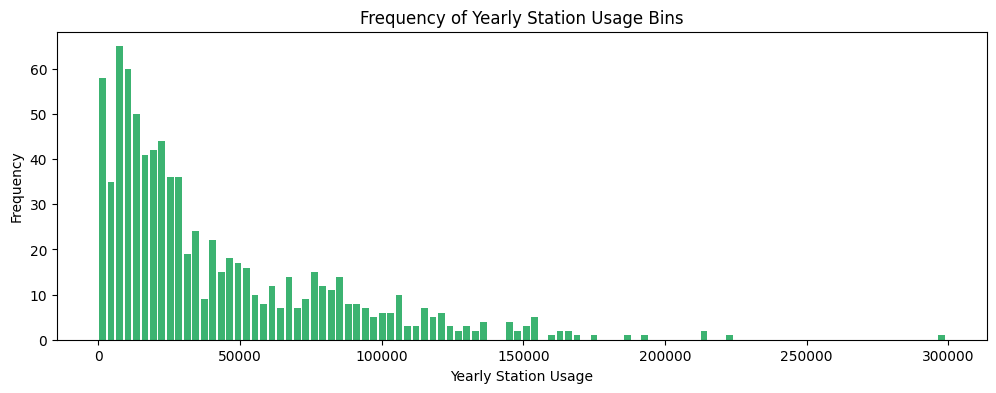

In [59]:
# Plot histogram of total station usage
plt.figure(figsize=(12, 4))
plt.hist(station_usage['total_usage'], bins=100, color='mediumseagreen', rwidth=0.8)
plt.xlabel('Yearly Station Usage')
plt.ylabel('Frequency')
plt.title('Frequency of Yearly Station Usage Bins')
plt.show()

The station usage is left-skewed and holds some distinct outliers with usage above 200,000; their validity will be inspected by plotting them on a map of New York to see if they are in central areas:


In [61]:
# Filter the stations with more than 200,000 yearly uses
top_stations = station_usage[station_usage['total_usage'] > 200000]

# Prepare data for plotting and plot
plot_data = top_stations.copy()
TITLE = 'Outlier Stations by Usage'
COLOR = plot_data['total_usage']
TEXT = "Station Id: " + plot_data['station_id'].astype(str) + "<br>" + "Total Usage: " + plot_data['total_usage'].astype(str)

single_map_plotter(TITLE, plot_data, COLOR, TEXT, ZOOM=12, SIZE=15)

From the plot it is seen that the heaviest outlier with close to 300,000 trip-starts and -ends per year is located by Grand Central Terminal while the others are placed centrally on Broadway and close to Union Square; all places where you would expect extreme usage, so these are kept and accepted as 'true' outliers.

A heat map of all stations based on their yearly usage can be plotted to discover patterns:

In [62]:
# Prepare data for plotting
plot_data = pd.DataFrame(station_usage)

# Prepare data for plotting and plot
TITLE = 'All Stations by Usage'
COLOR = plot_data['total_usage']
TEXT = "Station Id: " + plot_data['station_id'].astype(str) + "<br>" + "Total Usage: " + plot_data['total_usage'].astype(str)

single_map_plotter(TITLE, plot_data, COLOR, TEXT, ZOOM=10.5)

The above plot clearly shows that the most used stations are conentrated at the southern part of manhattan. With a general idea of the station popularity pattern, they can now be clustered into *Low*, *Medium* and *High* based on their yearly usage level: 

In [63]:
# Cluster with KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
station_usage['cluster'] = kmeans.fit_predict(station_usage[['total_usage']])

# Check the cluster centers to determine the popularity categories
cluster_centers = kmeans.cluster_centers_

# Sort cluster centers to assign popularity categories
sorted_centers = sorted(list(cluster_centers.flatten()))

# Assign categories
def assign_popularity_category(row):
    if row['total_usage'] <= sorted_centers[0]:
        return 'Low'
    elif row['total_usage'] <= sorted_centers[1]:
        return 'Medium'
    else:
        return 'High'

station_usage['popularity_category'] = station_usage.apply(assign_popularity_category, axis=1)
station_usage.head()

,station_id,latitude,longitude,total_usage,cluster,popularity_category
0,72.0,40.767272,-73.993929,76279.0,1,High
1,79.0,40.719116,-74.006667,54312.0,1,Medium
2,82.0,40.711174,-74.000165,20504.0,0,Medium
3,83.0,40.683826,-73.976323,26611.0,0,Medium
4,119.0,40.696089,-73.978034,6957.0,0,Low


With the clustering done, the distribution of the popularity categories is plotted in a histogram:

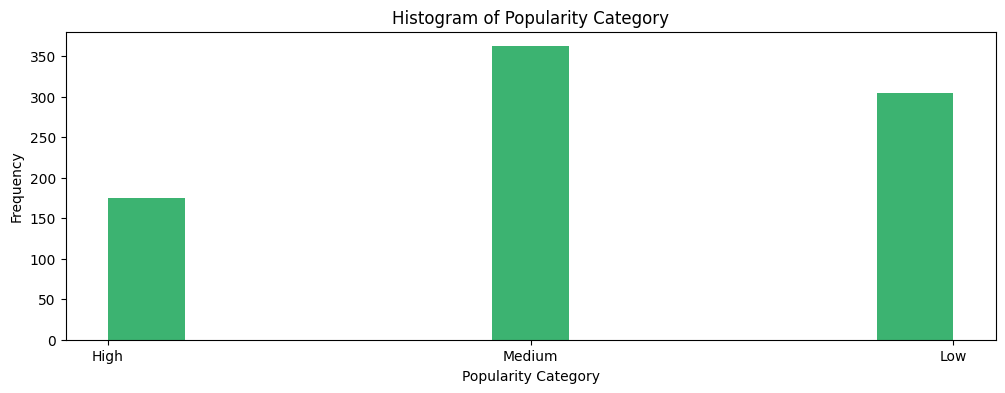

In [64]:
# Plot histogram of popularity categories
plt.figure(figsize=(12, 4))
plt.hist(station_usage['popularity_category'], bins='auto', color='mediumseagreen')
plt.title('Histogram of Popularity Category')
plt.xlabel('Popularity Category')
plt.ylabel('Frequency')
plt.show()

The categories are slightly unevenly distributed, but are uniform enough to function as a classification problem. The stations can again be plotted on a map to explore whether the clusters align with the above detected pattern of popular stations:

In [65]:
# Prepare data for plotting
plot_data = pd.DataFrame(station_usage)

# Prepare data for plotting and plot
TITLE = 'Clustered Stations'
COLOR = plot_data['cluster']
TEXT = "Station Id: " + plot_data['station_id'].astype(str) + "<br>" + "Total Usage: " + plot_data['popularity_category'].astype(str)

single_map_plotter(TITLE, plot_data, COLOR, TEXT, LEGEND=True)

As expected, the *High*-usage stations have home on southern Manhattan, the *Medium* ones are a bit more spread out and the *Low* ones are mostly places on the outskirts.

## 4.2 Incorporating Points of Interest

With the stations clustered into popularity, the dataset can now be extended with POIs in the stations' proximity using the `osmnx` module to fetch geospatial information. For each station, the number of each instance of different POIs (like bus stops, schools, museums etc.) within a 200m and a 1000m radius will be added as features. In addition, atributes with distance of closest POIs will be added - within a maximum limit of 5000m away.

To get an idea of the different types of POIs in Manhattan, these can be fetched with oxmnx's `geometries_from_place`:

In [7]:
# Define a standard place name for the query
place = "Manhattan, New York"

try:
    # Process unique values for 'amenity'
    pois = ox.features_from_place(place, tags={'amenity': True})
    unique_amenities = pois['amenity'].unique().tolist()
    print(f"Number of unique amenities: {len(unique_amenities)}")
    print(f"Unique amenities: {unique_amenities}")

    # Process unique values for 'public_transport'
    pois = ox.features_from_place(place, tags={'public_transport': True})
    unique_public_transport = pois['public_transport'].unique().tolist()
    print(f"\nNumber of unique public transport options: {len(unique_public_transport)}")
    print(f"Unique public transport options: {unique_public_transport}")

    # Process unique values for 'landuse'
    pois = ox.features_from_place(place, tags={'landuse': True})
    unique_landuse = pois['landuse'].unique().tolist()
    print(f"\nNumber of unique landuse types: {len(unique_landuse)}")
    print(f"Unique landuse types: {unique_landuse}")

    # Process unique values for 'highway'
    pois = ox.features_from_place(place, tags={'highway': True})
    unique_highway = pois['highway'].unique().tolist()
    print(f"\nNumber of unique highway types: {len(unique_highway)}")
    print(f"Unique highway types: {unique_highway}")

except Exception as e:
    print(f"An error occurred: {e}")

Number of unique amenities: 127
Unique amenities: ['drinking_water', 'toilets', 'fast_food', 'school', 'social_facility', 'university', 'college', 'place_of_worship', 'hospital', 'clinic', 'research_institute', 'restaurant', 'theatre', 'post_office', 'arts_centre', 'cinema', 'bar', 'bench', 'courthouse', 'community_centre', 'doctors', 'fire_station', 'library', 'parking', 'police', 'prison', 'pub', 'cafe', 'bicycle_parking', 'ice_cream', 'atm', 'telephone', 'post_box', 'fountain', 'bank', 'pharmacy', 'ferry_terminal', 'motorcycle_parking', 'stripclub', 'marketplace', 'parking_entrance', 'waste_basket', 'taxi', 'bus_station', 'bbq', 'bicycle_rental', 'bureau_de_change', 'disused:restaurant', 'car_sharing', 'fuel', 'kindergarten', 'studio', 'dentist', 'car_rental', 'nightclub', 'shoe_repair', 'salon', 'urgent_care', 'spa', 'events_venue', 'money_transfer', 'public_bath', 'childcare', 'boat_rental', 'veterinary', 'vending_machine', 'language_school', 'animal_boarding', 'food_court', 'dojo

For computational efficiency, a subset of tags are selected for feature production:

In [8]:
# Manually select important tags
filtered_amenities = ['cafe', 'fast_food', 'restaurant', 'pub', 'bar', 'park', 'bus_station', 'ferry_terminal', 
                      'taxi', 'bank', 'pharmacy', 'clinic', 'theatre', 'cinema', 'arts_centre', 
                      'library', 'school', 'university', 'college', 'townhall', 'plaza', 'music_venue']
print(f"Number of filtered amenity values: {len(filtered_amenities)}")

filtered_highway = ['bus_stop', 'cycleway', 'living_street']
print(f"Number of filtered highway values: {len(filtered_highway)}")

filtered_transport = ['station', 'platform', 'service_center']
print(f"Number of filtered transport values: {len(filtered_transport)}")

filtered_landuse = ['residential', 'retail', 'construction', 'industrial', 
                    'commercial', 'railway', 'harbour', 'education', 'military']
print(f"Number of filtered landuse values: {len(filtered_landuse)}")

# Calculate number of features
unique_tags = len(filtered_landuse)+len(filtered_transport)+len(filtered_amenities)+len(filtered_highway)

print(f"\nTotal unique tags for closest_distance_amenity_x and instances_amenity_x: {unique_tags}")
print(f"Number of features to extend dataset with: {3*unique_tags}")

Number of filtered amenity values: 22
Number of filtered highway values: 3
Number of filtered transport values: 3
Number of filtered landuse values: 9

Total unique tags for closest_distance_amenity_x and instances_amenity_x: 37
Number of features to extend dataset with: 111


To aid in the creation of 111 of the new features, the function `find_closest_poi` below will be used:

In [146]:
def find_closest_poi(lat, lon, poi_type='amenity', value='restaurant'):
    location_point = (lat, lon)
    
    try:
        # Use OSMnx to download the POIs within 5,000 meters
        pois = ox.features_from_point(location_point, tags={poi_type: value}, dist=5000)
    except Exception:
        return 5000, 0, 0

    valuecount_200 = 0
    valuecount_1000 = 0
    min_distance = float('inf')
    for _, row in pois.iterrows():
        geom = row.geometry
        poi_point = None
        if isinstance(geom, shapely.geometry.Point):
            poi_point = (geom.y, geom.x)
        elif isinstance(geom, shapely.geometry.Polygon):
            poi_point = (geom.centroid.y, geom.centroid.x)
        elif isinstance(geom, shapely.geometry.LineString):
            poi_point = (geom.coords[0][1], geom.coords[0][0])
        if poi_point:
            distance = haversine(location_point, poi_point, unit=Unit.METERS)
            if distance < min_distance:
                min_distance = distance
            if distance <= 1000:
                valuecount_1000 += 1
                if distance <= 200:
                    valuecount_200 += 1

    return min_distance if min_distance < 5000 else 5000, valuecount_200, valuecount_1000

def calculate_distances_instances(row, amenities, landuses, transports, highways):
    lon, lat = row['longitude'], row['latitude']
    distances = {}
    instances_200 = {}
    instances_1000 = {}

    for amenity in amenities:
        distance, instance_200, instance_1000 = find_closest_poi(lat, lon, 'amenity', amenity)
        distances[f'dist_amenity_{amenity}'] = distance
        instances_200[f'instance_200_amenity_{amenity}'] = instance_200
        instances_1000[f'instance_1000_amenity_{amenity}'] = instance_1000

    for landuse in landuses:
        distance, instance_200, instance_1000 = find_closest_poi(lat, lon, 'landuse', landuse)
        distances[f'dist_landuse_{landuse}'] = distance
        instances_200[f'instance_200_landuse_{landuse}'] = instance_200
        instances_1000[f'instance_1000_landuse_{landuse}'] = instance_1000

    for transport in transports:
        distance, instance_200, instance_1000 = find_closest_poi(lat, lon, 'public_transport', transport)
        distances[f'dist_transport_{transport}'] = distance
        instances_200[f'instance_200_transport_{transport}'] = instance_200
        instances_1000[f'instance_1000_transport_{transport}'] = instance_1000

    for highway in highways:
        distance, instance_200, instance_1000 = find_closest_poi(lat, lon, 'highway', highway)
        distances[f'dist_highway_{highway}'] = distance
        instances_200[f'instance_200_highway_{highway}'] = instance_200
        instances_1000[f'instance_1000_highway_{highway}'] = instance_1000

    return distances, instances_200, instances_1000

In [158]:
# Example usage of the function find_closest_poi
lat = station_usage['latitude'][34]
lon = station_usage['longitude'][34]

# For amenity
amenity_distance, instances_200, instances_1000 = find_closest_poi(lat, lon, poi_type='amenity', value='toilets')
print(f"Closest toilet is {amenity_distance:.2f} m away; there are {instances_200} toilet(s) in a 200 m radius and {instances_1000} within 1000 m")

# For highway
highway_distance, instances_200, instances_1000 = find_closest_poi(lat, lon, poi_type='highway', value='cycleway')
print(f"Closest cycleway is {highway_distance:.2f} m away; there is/are {instances_200} cycleway(s) in a 200 m radius and {instances_1000} within 1000 m")

# For landuse
landuse_distance, instances_200, instances_1000 = find_closest_poi(lat, lon, poi_type='landuse', value='cemetery')
print(f"Closest cemetery is {landuse_distance:.2f} m away; there is/are {instances_200} cemeteries in a 200 m radius and {instances_1000} within 1000 m")

# For public transport
public_transport_distance, instances_200, instances_1000 = find_closest_poi(lat, lon, poi_type='public_transport', value='station')
print(f"Closest station is {public_transport_distance:.2f} m away; there is/are {instances_200} station(s) in a 200 m radius and {instances_1000} within 1000 m")

Closest toilet is 157.74 m away; there are 1 toilet(s) in a 200 m radius and 5 within 1000 m
Closest cycleway is 285.01 m away; there is/are 0 cycleway(s) in a 200 m radius and 7 within 1000 m
Closest cemetery is 711.41 m away; there is/are 0 cemeteries in a 200 m radius and 1 within 1000 m
Closest station is 92.42 m away; there is/are 1 station(s) in a 200 m radius and 19 within 1000 m


For all stations, a dictionary with closest distance to-, number of 200m-radius instances of- and number of 1000m-radius instances of each POI is computed and the features added to the `station_usage` dataframe:

In [ ]:
# Create list of distance dictionaries
distances_list = []
instances_200_list = []
instances_1000_list = []
for index, row in tqdm(station_usage.iterrows(), total=station_usage.shape[0]):
    distances, instances_200, instances_1000 = calculate_distances_instances(row, filtered_amenities, filtered_landuse, filtered_transport, filtered_highway)
    distances_list.append(distances)
    instances_200_list.append(instances_200)
    instances_1000_list.append(instances_1000)

# Convert the lists of dictionaries into a dataframe and pickle it
distances_df = pd.DataFrame(distances_list)
instances_200_df = pd.DataFrame(instances_200_list)
instances_1000_df = pd.DataFrame(instances_1000_list)

# Pickle dataframes
with open('distances_df.pkl', 'wb') as f:
    pickle.dump(distances_df, f)
print("distances_df pickled successfully!")

with open('instances_200_df.pkl', 'wb') as f:
    pickle.dump(instances_200_df, f)
print("instances_200_df pickled successfully!")

with open('instances_1000_df.pkl', 'wb') as f:
    pickle.dump(instances_1000_df, f)
print("instances_1000_df pickled successfully!")


# Join distances_df with the original station_usage dataframe to add the new columns and pickle it
station_usage_dist = station_usage.join(distances_df)
station_usage_dist_inst200 = station_usage_dist.join(instances_200_df)
station_usage_dist_inst200_inst1000 = station_usage_dist_inst200.join(instances_1000_df)

# Pickle dataframes
with open('station_usage_dist_inst200_inst1000.pkl', 'wb') as f:
    pickle.dump(station_usage_dist_inst200_inst1000, f)
print("station_usage_dist_inst200_inst1000 pickled successfully!")

To avoid having to compute the features for every kernel-initialization, the dataframe is loaded from a pickle file and is ready to use for dimensionality reduction and classification:

In [66]:
# Loading extended dataset
file_path = 'Extension data/station_usage_dist_inst200_inst1000.pkl'
with open(file_path, 'rb') as file:
    extended_station_usage = pickle.load(file)

extended_station_usage.head()

,station_id,start_count,end_count,total_usage,latitude,longitude,cluster,popularity_category,dist_amenity_cafe,dist_amenity_fast_food,...,instance_1000_landuse_railway,instance_1000_landuse_harbour,instance_1000_landuse_education,instance_1000_landuse_military,instance_1000_transport_station,instance_1000_transport_platform,instance_1000_transport_service_center,instance_1000_highway_bus_stop,instance_1000_highway_cycleway,instance_1000_highway_living_street
0,519.0,149660.0,149359,299019.0,40.751873,-73.977706,2,High,12.462342,105.242309,...,0,0,0,0,19,176,4,125,22,3
1,497.0,108405.0,112879,221284.0,40.737050,-73.990093,2,High,41.586128,30.875647,...,0,0,0,0,20,143,0,107,6,6
2,435.0,106857.0,108402,215259.0,40.741740,-73.994156,2,High,24.637588,43.991644,...,0,0,0,0,23,144,0,102,8,11
3,402.0,105141.0,108747,213888.0,40.740343,-73.989551,2,High,14.060229,100.494818,...,0,0,0,0,21,146,0,106,6,11
4,426.0,93387.0,98261,191648.0,40.717548,-74.013221,2,High,301.655049,256.271831,...,0,0,0,0,19,81,0,51,39,0


## 4.3 Splitting the Data

The data is randomly divided into train- and test-sets, while cross-validation will handle training-validation without requiring a dedicated validation set. The test-set will provide quantitative evaluation, while model generalization will be qualitatively assessed by inferring locations in Copenhagen - ideally, testing would involve a complete Citi Bike dataset from another city.

In [67]:
def category_to_number(category):
    if category == 'Low':
        return 1
    elif category == 'Medium':
        return 2
    elif category == 'High':
        return 3
    
def number_to_category(number):
    if number == 1:
        return 'Low'
    elif number == 2:
        return 'Medium'
    elif number == 3:
        return 'High'

In [68]:
# Setting 'station_id' as the index
extended_station_usage.set_index('station_id', inplace=True)

# Defining Y and X
Y = extended_station_usage['popularity_category'].map(category_to_number)
X = extended_station_usage.drop(columns=['cluster', 'popularity_category', 'longitude', 'latitude', 
                                         'total_usage', 'start_count', 'end_count'])

# Normalizing the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Spliting data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Y, test_size=0.3, random_state=42)
print(f"""
Training data X shape: {X_train.shape}
Training data y shape: {y_train.shape}
Testing data X shape: {X_test.shape}
Testing data y shape: {y_test.shape}""")


Training data X shape: (588, 111)
Training data y shape: (588,)
Testing data X shape: (253, 111)
Testing data y shape: (253,)


## 4.4 Reducing Dimensions

With 588 stations and 111 attributes in the training data, PCA is used to reduce dimensionality and visually assess its impact on model performance and class separability.

In [69]:
# Performing PCA on the training data
pca = PCA()  
principal_components = pca.fit_transform(X_train)

The class seperability of the first three PCs is assessed through a visualization:

In [70]:
# Plotting the first three principal components
fig = go.Figure()
for label in [1, 2, 3]:
    filtered_pc = principal_components[y_train == label]
    fig.add_trace(go.Scatter3d(x=filtered_pc[:, 0], y=filtered_pc[:, 1], z=filtered_pc[:, 2], mode='markers', marker=dict(size=3), name=f'Class {number_to_category(label)}'))

fig.update_layout(
    title='PCA: First three Principal Components',
    scene=dict(xaxis_title='Principal Component 1', yaxis_title='Principal Component 2', zaxis_title='Principal Component 3'),
    margin=dict(l=0, r=0, b=0, t=0))
fig.show()

The classes appear to be somewhat separable from the first three PCs alone; giving hope that a classifier could perform well. The variance explainability by the PCs are also analyzed:

In [71]:
# Calculating the cumulative sum of explained variance
EV_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)

In [72]:
# Plotting the cumulative sum of explained variance
x_plot = list(range(1, len(EV_ratio_cumsum) + 1))

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_plot, y=EV_ratio_cumsum, mode='lines+markers', line=dict(color='coral'), name='Cumulative Explained Variance'))

shapes = [
    dict(type='line', x0=1, y0=0.85, x1=len(EV_ratio_cumsum), y1=0.85, line=dict(color='mediumseagreen', dash='dash')),
    dict(type='line', x0=1, y0=0.90, x1=len(EV_ratio_cumsum), y1=0.90, line=dict(color='mediumaquamarine', dash='dash')),
    dict(type='line', x0=1, y0=0.95, x1=len(EV_ratio_cumsum), y1=0.95, line=dict(color='mediumturquoise', dash='dash'))]

annotations = [
    dict(xref='paper', x=0.945, y=0.85, xanchor='left', yanchor='middle', text='85% EV', showarrow=False),
    dict(xref='paper', x=0.945, y=0.90, xanchor='left', yanchor='middle', text='90% EV', showarrow=False),
    dict(xref='paper', x=0.945, y=0.95, xanchor='left', yanchor='middle', text='95% EV', showarrow=False)]

fig.update_layout(title='Explained Variance (EV) by Principal Components', xaxis_title='Number of Components', yaxis_title='Cumulative Explained Variance', shapes=shapes, annotations=annotations, title_x=0.5, width=900,  height=400)
fig.show()

It can be seen that the first 38 PCs explain 85% of the variance in the dataset; the original data and data projected onto these PCs will be used in the following classification.

## 4.5 Training and Evaluating Classifiers

The original- and PCA-projected datasets are used to train a RandomForest (RF) station popularity classifier, whereafter a SVM and RF are optimised and compared in performance. First, the data is projected onto the PCs:

In [73]:
# Performing PCA with the 38 PCs from before
pca = PCA(n_components=38)
X_train_pca = pca.fit_transform(X_train)

# Transforming the test data with the same PCA object
X_test_pca = pca.transform(X_test)

print(f"""
Training data X shape before PCA: {X_train.shape}
Training data X shape after PCA: {X_train_pca.shape}

Testing data X shape before PCA: {X_test.shape}
Testing data X shape after PCA: {X_test_pca.shape}""")


Training data X shape before PCA: (588, 111)
Training data X shape after PCA: (588, 38)

Testing data X shape before PCA: (253, 111)
Testing data X shape after PCA: (253, 38)


An RF classifier is trained on both datasets and evaluated:

In [74]:
# Training RF models on original and PCA data
model_rf = RandomForestClassifier(n_estimators=100, random_state=0)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

model_pca_rf = RandomForestClassifier(n_estimators=100, random_state=0)
model_pca_rf.fit(X_train_pca, y_train)
y_pred_pca_rf = model_pca_rf.predict(X_test_pca)

# Evaluating model performance
print(f"""
Classification Reports for Random Forest
For original data:
{classification_report(y_test, y_pred_rf)}
For PCA data:
{classification_report(y_test, y_pred_pca_rf)}""")


Classification Reports for Random Forest
For original data:
              precision    recall  f1-score   support

           1       0.75      0.72      0.74        87
           2       0.70      0.75      0.72       110
           3       0.82      0.73      0.77        56

    accuracy                           0.74       253
   macro avg       0.76      0.74      0.75       253
weighted avg       0.74      0.74      0.74       253

For PCA data:
              precision    recall  f1-score   support

           1       0.77      0.72      0.75        87
           2       0.65      0.76      0.70       110
           3       0.74      0.55      0.63        56

    accuracy                           0.70       253
   macro avg       0.72      0.68      0.69       253
weighted avg       0.71      0.70      0.70       253



The RF trained on the original data significantly outperforms using the PCA-projected data; since the dataset is so small, the original data is used in the analysis of RFs' versus SVMs' best-performing models found with Grid Search and Cross Validation:

In [75]:
# Finding the best RandomForrest using grid search
param_grid_rf = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}

rf = RandomForestClassifier(random_state=0)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [216]:
# Finding the best SVM using grid search
param_grid_svm = {'C': [0.1, 1, 10],
                  'gamma': [0.001, 0.01, 0.1, 1],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svm = SVC()
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train, y_train)

best_svm = grid_search_svm.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [217]:
# Getting test prdictions
y_pred_rf = best_rf.predict(X_test)
y_pred_svm = best_svm.predict(X_test)

# Evaluating the models' performances
print(f"""
Classification Report for Best Random Forest:
{classification_report(y_test, y_pred_rf)}
Classification Report for Best SVM:
{classification_report(y_test, y_pred_svm)}""")


Classification Report for Best Random Forest:
              precision    recall  f1-score   support

           1       0.78      0.74      0.76        87
           2       0.70      0.75      0.72       110
           3       0.78      0.75      0.76        56

    accuracy                           0.74       253
   macro avg       0.75      0.74      0.75       253
weighted avg       0.75      0.74      0.74       253

Classification Report for Best SVM:
              precision    recall  f1-score   support

           1       0.75      0.71      0.73        87
           2       0.66      0.70      0.68       110
           3       0.74      0.71      0.73        56

    accuracy                           0.71       253
   macro avg       0.72      0.71      0.71       253
weighted avg       0.71      0.71      0.71       253



The SVM, though performing well, is outperformed by the RF with an accuracy of 0.74 and weighted F1-score of 0.74.

## 4.6 Classifying Stations in Denmark

To qualitatively test the model's ability to classify station popularity, a set of locations in Copenhagen is fed through the model:

In [222]:
# Creating a dataframe of test locations
location_data = {
    "hovedbanegaarden": {"latitude": 55.673180471596154, "longitude": 12.565765569812863},
    "noerreport_station": {"latitude": 55.683290605990464, "longitude": 12.571702217250397},
    "copenhagen_opera": {"latitude": 55.68155581406397, "longitude": 12.601795728501502},
    "remote_bus_stop_lyngby": {"latitude": 55.7716820545397, "longitude": 12.474858237034876},
    "lyngby_station": {"latitude": 55.768306524242625, "longitude": 12.502996802623972},
    "dtu_bygning_101": {"latitude": 55.785855614456054, "longitude": 12.523926652438307}
}

test_locations = pd.DataFrame(location_data).T.reset_index()
test_locations.rename(columns={'index': 'location_name'}, inplace=True)
print("Test locations:")
test_locations.head()

Test locations:


,location_name,latitude,longitude
0,hovedbanegaarden,55.673180,12.565766
1,noerreport_station,55.683291,12.571702
2,copenhagen_opera,55.681556,12.601796
3,remote_bus_stop_lyngby,55.771682,12.474858
4,lyngby_station,55.768307,12.502997


In [223]:
# Getting POI data for each test location
distances_list = []
instances_200_list = []
instances_1000_list = []
for index, row in tqdm(test_locations.iterrows(), total=test_locations.shape[0]):
    distances, instances_200, instances_1000 = calculate_distances_instances(row, filtered_amenities, filtered_landuse, filtered_transport, filtered_highway)
    distances_list.append(distances)
    instances_200_list.append(instances_200)
    instances_1000_list.append(instances_1000)

# Joining fetched POI features into a single dataframe
distances_df = pd.DataFrame(distances_list)
instances_200_df = pd.DataFrame(instances_200_list)
instances_1000_df = pd.DataFrame(instances_1000_list)

test_locations_dist = test_locations.join(distances_df)
test_locations_dist_inst200 = test_locations_dist.join(instances_200_df)
test_locations_dist_inst200_inst1000 = test_locations_dist_inst200.join(instances_1000_df)

100%|██████████| 6/6 [03:09<00:00, 31.54s/it]


In [224]:
# Creating and normalizing data for inference
X_infer = test_locations_dist_inst200_inst1000.drop(columns=['latitude', 'longitude'])
X_infer.set_index('location_name', inplace=True)

X_infer_normalized = scaler.fit_transform(X_infer)

In [229]:
# Performing inference and mapping prediction to popularity
y_pred_infer = best_rf.predict(X_infer_normalized)
categorical_predictions = [number_to_category(num) for num in y_pred_infer]
location_names = test_locations_dist_inst200_inst1000['location_name'].copy()
predictions_df = pd.DataFrame({'location_name': location_names, 'prediction': categorical_predictions})

print("Popularity predictions for test locations:")
predictions_df.head() 

Popularity predictions for test locations:


,location_name,prediction
0,hovedbanegaarden,High
1,noerreport_station,High
2,copenhagen_opera,Medium
3,remote_bus_stop_lyngby,Low
4,lyngby_station,Medium


These predictions closely match the anticipated patterns of bike station usage. While this is a qualitative assessment focusing on select sites, the model demonstrates an impressive ability to generalize patterns learned in NYC and apply them to locations in Denmark.

# 5 Conclusion

The predictive and exploratory challenges demonstrated the business value to be gained by employing ML models. With the trained predicive linear regression and classifying random forest models, Citi Bike can optimize their nightly bike redistribution in NYC and determine appropriate station sizes when expanding their operation respectively.

___
# Individual contributions

| Section              | August | Phillip | Jonas | Line |
|----------------------|--------|---------|-------|------|
| Introduction         | ✓      |  ✓      |   ✓   |    ✓ |
| Data Analysis        | ✓      | ✓       |  ✓    |   ✓  |
| Prediction Challenge | ✓      | ✓       |       |      |
| Exploratory Challenge|        |         | ✓     |  ✓   |
| Conclusion           |  ✓     |     ✓   |   ✓   |  ✓   |

___
# Appendix

## A: Word counter

In [199]:
# Used to count words in Markdown cells; run in separate notebook

import json

with open('project_second_draft.ipynb', encoding='utf-8') as json_file:
    data = json.load(json_file)

start = False
end = False

wordCount = 0
for each in data['cells']:
    if end: 
        break
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if '#' not in word and '___' not in word]
            if temp==['Initialization']:
                start = True
            if temp==['Individual', 'contributions']:
                end = True
                break
            
            if start == True:
                wordCount = wordCount + len(temp)
            
print(f"Wordcount excluding Contributions and Appendix: {wordCount}")

Wordcount excluding Contributions and Appendix: 2496
